In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import reedsolo as rs

In [2]:
def check_pattern(cells):
    """
    Check if the mean value of each cell in cells is within a tolerance of the corresponding value in the pattern.
    """
    pattern = [0, 255, 0, 0, 0, 255, 0]  # 1:1:3:1:1 pattern
    tolerance = 100
    results = [abs(int(np.mean(cell)) - pat) <= tolerance for cell, pat in zip(cells, pattern)]
    return all(results)

def rotate_image(image, degrees):
    return np.rot90(image, degrees // 90)

def check_valid_format(og, qr_cells, grid_cells_num, grid_cell_size):
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)
    ecl = [int(not(c)) for c in qr_cells_numeric[grid_cells_num-2:grid_cells_num, 8]]
    mask = [int(not(c)) for c in qr_cells_numeric[grid_cells_num-3:grid_cells_num-6:-1, 8]]
    fec = np.concatenate(([qr_cells_numeric[grid_cells_num-6, 8]], [qr_cells_numeric[grid_cells_num-7, 8]], qr_cells_numeric[8, grid_cells_num-8:grid_cells_num][::-1]))  # Reverse to get from col 20 to col 13
    fec = [int(not(c)) for c in fec]

    ecl_check = [int(not(c)) for c in qr_cells_numeric[8, :2]]
    mask_check = [int(not(c)) for c in qr_cells_numeric[8, 2:5]]
    fec_check = np.concatenate(([qr_cells_numeric[8, 5]], [qr_cells_numeric[8, 7]], qr_cells_numeric[7:9,8][::-1], qr_cells_numeric[0:6,8][::-1]))
    fec_check = [int(not(c)) for c in fec_check]

    print(ecl + mask + fec == ecl_check + mask_check + fec_check)
    if not (ecl + mask + fec == ecl_check + mask_check + fec_check):
        revert = rotate_image(qr_cells, 270)
        return cv2.flip(og, 1).reshape((grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size)).swapaxes(1, 2)
    else:
        return qr_cells

def correct_orientation(og, qr_cells, grid_cells_num, grid_cell_size):
    """
    Correct the orientation of the QR code by checking the patterns in the corners and rotating if necessary.
    """
    # Check patterns in the corners
    bottom_right = qr_cells[grid_cells_num - 4, -7:], qr_cells[-7:, grid_cells_num-4]
    top_right = qr_cells[3, -7:], qr_cells[:7, grid_cells_num-4]
    bottom_left = qr_cells[grid_cells_num-4, :7], qr_cells[-7:, 3]


    # If the bottom right corner does not match the pattern, the QR code is in the correct orientation
    if not any(map(check_pattern, bottom_right)):
        return qr_cells

    # If all corners match the pattern, rotate 180 degrees
    if all(map(check_pattern, top_right + bottom_left)):
        return rotate_image(qr_cells, 180)

    # If the top right and bottom right corners match the pattern, rotate 270 degrees
    if all(map(check_pattern, top_right + bottom_right)):
        rotated = rotate_image(qr_cells, 90)
        return check_valid_format(og, rotated, grid_cells_num, grid_cell_size)


    # If the bottom left and bottom right corners match the pattern, rotate 90 degrees
    if all(map(check_pattern, bottom_left + bottom_right)):
        return rotate_image(qr_cells, 270)

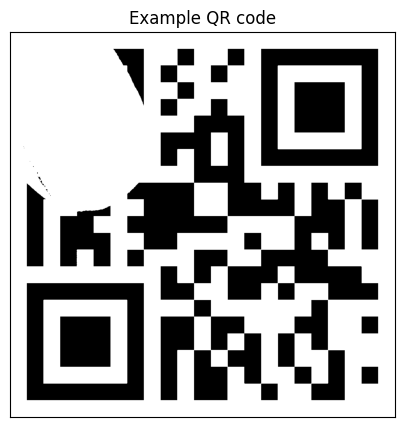

In [3]:
img = cv2.imread("preprocessed_images/output_7.png", cv2.IMREAD_GRAYSCALE)
_, img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.title('Example QR code')
plt.imshow(img, cmap='gray');

In [4]:
grid_cells_num = 21
grid_cell_size = 50

# gotta find a new way to get the qr without the quiet zone
start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break


for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
    if end_col != -1:
        break


top_border = min(start_row, max(start_col, img.shape[1] - end_col))
bottom_border = min(img.shape[0] - end_row, max(start_col, img.shape[1] - end_col))
left_border = min(start_col, max(start_row, img.shape[0] - end_row))
right_border = min(img.shape[1] - end_col, max(start_row, img.shape[0] - end_row))

print(top_border, bottom_border, left_border, right_border)

46 46 37 46


In [5]:
qr_no_quiet_zone = img[top_border:img.shape[0] - bottom_border, left_border: img.shape[1] - right_border]
qr_no_quiet_zone = cv2.resize(qr_no_quiet_zone, (grid_cells_num * grid_cell_size, grid_cells_num * grid_cell_size), interpolation=cv2.INTER_AREA)

In [6]:
# ...into grid cells
qr_cells = qr_no_quiet_zone.reshape((
    grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size,
)).swapaxes(1, 2)
print(qr_cells.shape)

(21, 21, 50, 50)


In [7]:
corrected_qr = correct_orientation(qr_no_quiet_zone, qr_cells, grid_cells_num, grid_cell_size)

In [8]:
qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
for i, row in enumerate(corrected_qr):
    for j, cell in enumerate(row):
        qr_cells_numeric[i, j] = (np.median(cell) // 255)

# qr_cells_numeric = 1 - qr_cells_numeric
print(qr_cells_numeric)

[[1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0]
 [1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 0]
 [1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0]
 [1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1]
 [0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0]
 [0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0]
 [0 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0]
 [0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1]
 [1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0]
 [0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1]
 [0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0]
 [0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1]
 [0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 1]
 [0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1]]


In [9]:
img_grid_inv = 1 - qr_cells_numeric

In [10]:
ecl = img_grid_inv[8, 0:2]
mask = img_grid_inv[8, 2:5]

In [11]:
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

# UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)
UP8, UP4, DOWN8, DOWN4, CW8, CCW8, UP_IRR, DOWN_IRR, CCW_IRR, UP_CORNER, DOWN_CORNER, UP_SKIP_TIM, DOWN_SKIP_TIM,\
DOWN_SKIP_ALIGN, UP_ALIGN, CCW_SKIP_TIM, UP_SKIP_FORMAT  = range(17)

In [12]:
fec = []
fec.append(qr_cells_numeric[8, 5])
fec.append(qr_cells_numeric[8, 7])
fec.extend(qr_cells_numeric[0:6, 8])
fec.extend(qr_cells_numeric[7:9, 8])
fec = [int(c) for c in fec]

In [13]:
format_info = [ecl, mask, fec]
format_info = [bit for sub_format in format_info for bit in sub_format]

In [14]:
def calculate_hamming_distance(seq1, seq2):
    return sum(bit1 != bit2 for bit1, bit2 in zip(seq1, seq2))

def fix_format_info(format_info):
    valid_format_sequence = [
      [1,0,1,0,1,0,0,0,0,0,1,0,0,1,0], # 00 000
      [1,0,1,0,0,0,1,0,0,1,0,0,1,0,1], # 00 001
      [1,0,1,1,1,1,0,0,1,1,1,1,1,0,0], # 00 010
      [1,0,1,1,0,1,1,0,1,0,0,1,0,1,1], # 00 011
      [1,0,0,0,1,0,1,1,1,1,1,1,0,1,1], # 00 100
      [1,0,0,0,0,0,0,1,1,0,0,1,1,1,0], # 00 101
      [1,0,0,1,1,1,1,1,0,0,1,0,1,1,1], # 00 110
      [1,0,0,1,0,1,0,1,0,1,0,0,0,0,0], # 00 111

      [1,1,1,0,1,1,1,1,1,0,0,0,1,0,0], # 01 000
      [1,1,1,0,0,1,0,1,1,1,1,0,0,1,1], # 01 001
      [1,1,1,1,1,0,1,1,0,1,0,1,0,1,0], # 01 010
      [1,1,1,1,0,0,0,1,0,0,1,1,1,0,1], # 01 011
      [1,1,0,0,1,1,0,0,0,1,0,1,1,1,1], # 01 100
      [1,1,0,0,0,1,1,0,0,0,1,1,0,0,0], # 01 101
      [1,1,0,1,1,0,0,0,1,0,0,0,0,0,1], # 01 110
      [1,1,0,1,0,0,1,0,1,1,1,0,1,1,0], # 01 111

      [0,0,1,0,1,1,0,1,0,0,0,1,0,0,1], # 10 000
      [0,0,1,0,0,1,1,1,0,1,1,1,1,1,0], # 10 001
      [0,0,1,1,1,0,0,1,1,1,0,0,1,1,1], # 10 010
      [0,0,1,1,0,0,1,1,1,0,1,0,0,0,0], # 10 011
      [0,0,0,0,1,1,1,0,1,1,0,0,0,1,0], # 10 100
      [0,0,0,0,0,1,0,0,1,0,1,0,1,0,1], # 10 101
      [0,0,0,1,1,0,1,0,0,0,0,1,1,0,0], # 10 110
      [0,0,0,1,0,0,0,0,0,1,1,1,0,1,1], # 10 111

      [0,1,1,0,1,0,1,0,1,0,1,1,1,1,1], # 11 000
      [0,1,1,0,0,0,0,0,1,1,0,1,0,0,0], # 11 001
      [0,1,1,1,1,1,1,0,0,1,1,0,0,0,1], # 11 010
      [0,1,1,1,0,1,0,0,0,0,0,0,1,1,0], # 11 011
      [0,1,0,0,1,0,0,1,0,1,1,0,1,0,0], # 11 100
      [0,1,0,0,0,0,1,1,0,0,0,0,0,1,1], # 11 101
      [0,1,0,1,1,1,0,1,1,0,1,1,0,1,0], # 11 110
      [0,1,0,1,0,1,1,1,1,1,0,1,1,0,1]  # 11 111
    ]

    # Initialize min_distance with a large number and min_seq with None
    min_distance = float('inf')
    min_seq = None

    for seq in valid_format_sequence:
        # Calculate the hamming distance between format_info and seq
        distance = calculate_hamming_distance(format_info, seq)

        # If the distance is 0, then we have found an exact match
        if distance == 0:
            return seq

        # If the distance is less than min_distance, update min_distance and min_seq
        if distance < min_distance:
            min_distance = distance
            min_seq = seq

    # If no exact match was found, return the sequence with the minimum hamming distance
    format_info = min_seq
    return format_info

In [15]:
fix_format_info(format_info)

ecl = format_info[:2]
mask = format_info[2:5]
fec = format_info[5:]

# ecl[0] ^= 1
# mask[0] ^= 1
# mask[2] ^= 1
# fec[5] ^= 1
# fec[8] ^= 1

# # And now we print...
mask_str = ''.join([str(c) for c in mask])

In [16]:
def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    #------------------------new directions just dropped-----------------------#
    if (direction == UP_IRR):
        row_offsets = [0, -1, -1, -2, -2, -3, -3, -4]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  1]
    if (direction == DOWN_IRR):
        row_offsets = [0,  1,  1,  2,  2,  3,  3,  4]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  1]
    if (direction == CCW_IRR):
        row_offsets = [0,  0, -1, -1, -2, -2, -2, -2]
        col_offsets = [0, -1,  0, -1,  0, -1, -2, -3]
    if (direction == UP_CORNER):
        row_offsets = [0, -1, -1, -2, -3, -3, -3, -3]
        col_offsets = [0,  1,  0,  1,  0,  1,  0, -1]
    if (direction == DOWN_CORNER):
        row_offsets = [0,  1,  1,  2,  2,  3,  3,  3]
        col_offsets = [0,  1, -1,  1, -1,  1,  0, -1]
    if (direction == UP_SKIP_TIM):
        row_offsets = [0, -1, -1, -3, -3, -4, -4, -5]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  1]
    if (direction == DOWN_SKIP_TIM):
        row_offsets = [0,  1,  1,  2,  2,  4,  4,  5]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  1]
    if (direction == DOWN_SKIP_ALIGN):
        row_offsets = [0,  0,  1,  1,  6,  6,  7,  7]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == UP_ALIGN):
        row_offsets = [0,  0, -1, -1, -2, -3, -4, -5]
        col_offsets = [0, -1,  0, -1, -1, -1, -1, -1]
    if (direction == CCW_SKIP_TIM):
        row_offsets = [0, -1, -1, -2, -2, -3, -3, -3]
        col_offsets = [0,  1,  0,  1,  0,  1,  0, -2]
    if (direction == UP_SKIP_FORMAT):
        row_offsets = [0,  1,  1,  2,  2,  3,  3,  -5]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  -1]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        # Modules corresponding to the dark areas of the mask are inverted.
        result.append(int(not cell_bit if mask_bit else cell_bit))
    return result[:4] if direction in [UP4, DOWN4] else result

In [17]:
enc_bits = apply_mask_general(21-1, 21-1, img_grid_inv, mask, UP8)[:4]

In [18]:
len_bits = apply_mask_general(21-3, 21-1, img_grid_inv, mask, UP8)
len_int = int(''.join([str(bit) for bit in len_bits]), 2)

In [19]:
v1_data_starting_indices = [
    [21-1,  21-1, UP4],
    [21-3,  21-1, UP8],
    [21-7,  21-1,  UP8],
    [21-11, 21-1,  CCW8],
    [21-10, 21-3,  DOWN8],
    [21-6,  21-3,  DOWN8],
    [21-2,  21-3,  CW8],
    [21-3,  21-5,  UP8],
    [21-7,  21-5,  UP8],
    [21-11, 21-5,  CCW8],
    [21-10, 21-7,  DOWN8],
    [21-6,  21-7,  DOWN8],
    [21-2,  21-7,  CW8],
    [21-3,  21-9,  UP8],
    [21-7,  21-9,  UP8],
    [21-11, 21-9,  UP8],
    [21-16, 21-9,  UP8],
    [21-20, 21-9,  CCW8],
    [21-19, 21-11, DOWN8],
    [21-14, 21-11, DOWN4],  # Special 4-byte block, reserved for END (if exists!)
    [21-12, 21-11, DOWN8],
    [21-8,  21-11, DOWN8],
    [21-4,  21-11, DOWN8],
    [21-9,  21-13, UP8],
    [21-12, 21-16, DOWN8],
    [21-9,  21-18, UP8],
    [21-12, 21-20, DOWN8],
]

v3_data_starting_indices = []
v4_data_starting_indices = []

In [20]:
ALPHANUMERIC_TABLE = {

    0: '0', 1: '1', 2: '2', 3: '3', 4: '4',
    5: '5', 6: '6', 7: '7', 8: '8', 9: '9',

    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E',
    15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O',
    25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y',
    35: 'Z',

    36: ' ', 37: '$', 38: '%', 39: '*',
    40: '+', 41: '-', 42: '.', 43: '/', 44: ':'
}

def bin_to_alphanum(bits):

    num = int(bits, 2)

    # This part is similar to saying that 78 = 7 * 10 + 8
    # Originally if we're encoding alpahnumeric characters for example TH (T:29, H:17)
    # We would get the binary string by converting 29 * 45 + 17 to binary

    first_num = num // 45
    first_char = ALPHANUMERIC_TABLE[first_num]

    second_num = num % 45
    second_char = ALPHANUMERIC_TABLE[second_num]

    return first_char + second_char

def decode_alphanumeric_v1():
    ans = ''
    data_string = ''
    for a, b, d in v1_data_starting_indices:
        bits = apply_mask_general(a, b, img_grid_inv, mask,  d)
        # Convert list of bits to string and concatenate to data_string
        data_string += ''.join([str(bit) for bit in bits])

    print(f"data_string: {data_string}")

    # Exclude the first 4 bits of the encoding type
    data_string = data_string[4:]
    print(f"data_string_no_enc: {data_string}")
    # The length should be read in the next 9 bits
    length = int(data_string[:9], 2)
    #print(f"length: {length}")

    data_string = data_string[9:]
    print(f"data_string_no_len: {data_string}")

    # Process the data 11 bits by 11 bits
    while length > 1:
        chars = bin_to_alphanum(data_string[:11])
        ans += chars
        print(f'{data_string[:11]} = {chars}')
        data_string = data_string[11:]
        length -= 2

    # If the number of characters in the to be decoded string is odd, the last character is represented in 6 bits
    if length == 1:
        last_char = ALPHANUMERIC_TABLE[int(data_string[:6], 2)]
        ans += last_char
        print(f'{data_string[:6]} = {last_char}')

    print(f'\nDecoded string: {ans}')

In [21]:
def decode_byte_mode_v1():
    message_bits = []
    message_bits.extend(enc_bits)
    message_bits.extend(len_bits)
    # Let me re-format this for better readability :)
    # First, let's read the data bytes, starting from the very first byte after enc and len
    byte_index = 0
    byte_stream = ''
    extracted_data_no_error_correction = ''
    for _ in range(len_int):
        start_i, start_j, dir = v1_data_starting_indices[byte_index]
        bits = apply_mask_general(start_i, start_j, img_grid_inv, mask, dir)
        bit_string = ''.join([str(bit) for bit in bits])
        extracted_data_no_error_correction += chr(int(bit_string, 2))
        byte_stream += bit_string
        message_bits.extend(bits)
        bit_string = ''.join([str(bit) for bit in bits])
        alpha_char = chr(int(bit_string, 2))
        print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
        byte_index += 1
    
    start_i, start_j, dir = v1_data_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_grid_inv, mask, dir)
    byte = bytes([int(byte_stream[i:i+8], 2) for i in range(0, len(byte_stream), 8)])
    message_bits.extend(bits)
    print(bits)
    byte_index += 1

    try:
        print(f'\ni.e., the data in the QR code as-is are "{byte.decode("utf-8")}"')
    except:
        print(f'\ni.e., the data in the QR code as-is are "{extracted_data_no_error_correction}"')

    for _ in range(25 - len_int - 1):
        start_i, start_j, dir = v1_data_starting_indices[byte_index]
        bits = apply_mask_general(start_i, start_j, img_grid_inv, mask, dir)
        message_bits.extend(bits)
        bit_string = ''.join([str(bit) for bit in bits])
        alpha_char = chr(int(bit_string, 2))
        print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
        byte_index += 1
    
    message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]

# Create the Reed-Solomon Codec for 7 ECC symbols (again, this is L)
    rsc = rs.RSCodec(nsym=7)

    # Decode the bytes with the 7-ECC RS Codec
    try:
        message_decoded = rsc.decode(message_bytes)
        rsc.maxerrata(verbose=True)
        data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:13+len_int*8]
        data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
        try:
            print(f'Data in message = "{data_bytes.decode(encoding="utf-8")}"')
        except:
            print(f'Data in message = "{data_bytes.decode(encoding="iso-8859-1")}"')
    except rs.ReedSolomonError as e:
        print(f'Error decoding the message: {str(e)}')
        # Extract data without error correction

In [22]:
enc = apply_mask_general(grid_cells_num-1, grid_cells_num-1, img_grid_inv, mask,UP4)

In [23]:
version = 1
if version == 1:
  if enc == [0, 0, 1, 0]:
    decode_alphanumeric_v1()
  else:
    decode_byte_mode_v1()
elif version == 3:
  decode_byte_mode_v3()
elif version == 4:
  decode_byte_mode_v4()

data_string: 0010110010101101111010000101001001001111110100010110100111100010001011110100010111011000011001101111011101100000101011000001000111101101100000101111100011100001100000000101101111111101010001101011010100000010
data_string_no_enc: 110010101101111010000101001001001111110100010110100111100010001011110100010111011000011001101111011101100000101011000001000111101101100000101111100011100001100000000101101111111101010001101011010100000010
data_string_no_len: 101111010000101001001001111110100010110100111100010001011110100010111011000011001101111011101100000101011000001000111101101100000101111100011100001100000000101101111111101010001101011010100000010
10111101000 = XR
01010010010 = ES
01111110100 = MM
01011010011 = G3
11000100010 = Y+
11110100010 = /J
11101100001 = -:
10011011110 = RV
11101100000 = -/
10101100000 = UQ
10001111011 = PM
01100000101 = H8
11110001110 = .:
00011000000 = 4C
00101101111 = 87
11110101000 = /P
11010110101 = %7
00000010 = 02


ValueError: invalid literal for int() with base 2: ''